# DistAwareAug Basic Usage Demo

This notebook demonstrates the basic usage of the DistAwareAug package for distribution-aware data augmentation. We'll create synthetic datasets, apply different augmentation methods, and visualize the results.

## Overview

DistAwareAug provides intelligent oversampling that:
- Fits distributions to minority class features
- Generates diverse synthetic samples
- Maintains feature value ranges
- Ensures sample diversity through distance-based filtering

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from collections import Counter
import sys
import os

# Add the parent directory to the path to import our package
# Get the current notebook directory and go up one level to the project root
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Added to Python path: {project_root}")
print(f"Current working directory: {os.getcwd()}")

# Import DistAwareAug components
try:
    from distawareaug import DistAwareAugmentor
    from distawareaug.distribution import DistributionFitter
    from distawareaug.distance import DistanceMetrics
    from distawareaug.utils import validate_data, check_class_balance
    print("✅ DistAwareAug components imported successfully!")
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("Available paths in sys.path:")
    for path in sys.path[:5]:  # Show first 5 paths
        print(f"  {path}")
    
    # Try alternative import approach
    print("\nTrying alternative import...")
    import importlib.util
    spec = importlib.util.find_spec("distawareaug")
    if spec is None:
        print("distawareaug package not found in any path")
    else:
        print(f"Found distawareaug at: {spec.origin}")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Added to Python path: /Users/admin/Documents/GitHub/DistAwareAug
Current working directory: /Users/admin/Documents/GitHub/DistAwareAug/examples
✅ DistAwareAug components imported successfully!
NumPy version: 2.3.3
Pandas version: 2.3.3


In [14]:
# Alternative: Direct file imports if package import fails
if 'DistAwareAugmentor' not in globals():
    print("📁 Attempting direct file imports...")
    
    # Check if distawareaug directory exists
    distawareaug_path = os.path.join(project_root, 'distawareaug')
    print(f"Looking for distawareaug at: {distawareaug_path}")
    print(f"Directory exists: {os.path.exists(distawareaug_path)}")
    
    if os.path.exists(distawareaug_path):
        print("Contents of distawareaug directory:")
        for item in os.listdir(distawareaug_path):
            print(f"  {item}")
            
        # Try importing individual modules directly
        try:
            sys.path.insert(0, distawareaug_path)
            
            # Import the main modules
            import augmentor
            import distribution  
            import distance
            import utils
            import config
            
            # Get the classes we need
            DistAwareAugmentor = augmentor.DistAwareAugmentor
            DistributionFitter = distribution.DistributionFitter
            DistanceMetrics = distance.DistanceMetrics
            validate_data = utils.validate_data
            check_class_balance = utils.check_class_balance
            
            print("✅ Direct module imports successful!")
            
        except Exception as e:
            print(f"❌ Direct import failed: {e}")
            
            # Last resort: show how to create a minimal version
            print("\n🔧 Creating minimal DistAwareAugmentor for demo...")
            
            class MinimalDistAwareAugmentor:
                def __init__(self, sampling_strategy='auto', diversity_threshold=0.1, 
                           distribution_method='kde', distance_metric='euclidean', random_state=None):
                    self.sampling_strategy = sampling_strategy
                    self.diversity_threshold = diversity_threshold  
                    self.distribution_method = distribution_method
                    self.distance_metric = distance_metric
                    self.random_state = random_state
                    
                def fit_resample(self, X, y):
                    # Simple SMOTE-like implementation for demo
                    from sklearn.neighbors import NearestNeighbors
                    
                    # Find minority class
                    unique_classes, counts = np.unique(y, return_counts=True)
                    minority_class = unique_classes[np.argmin(counts)]
                    majority_count = np.max(counts)
                    minority_count = np.min(counts)
                    
                    # Get minority class data
                    minority_mask = y == minority_class
                    minority_data = X[minority_mask]
                    
                    # Generate synthetic samples (simplified)
                    n_synthetic = majority_count - minority_count
                    if n_synthetic <= 0:
                        return X, y
                        
                    # Simple interpolation between minority samples
                    np.random.seed(self.random_state)
                    synthetic_samples = []
                    
                    for _ in range(n_synthetic):
                        # Pick two random minority samples
                        idx1, idx2 = np.random.choice(len(minority_data), 2, replace=True)
                        sample1, sample2 = minority_data[idx1], minority_data[idx2]
                        
                        # Interpolate
                        alpha = np.random.random()
                        synthetic_sample = alpha * sample1 + (1 - alpha) * sample2
                        synthetic_samples.append(synthetic_sample)
                    
                    if synthetic_samples:
                        synthetic_samples = np.array(synthetic_samples)
                        X_resampled = np.vstack([X, synthetic_samples])
                        y_synthetic = np.full(len(synthetic_samples), minority_class)
                        y_resampled = np.hstack([y, y_synthetic])
                    else:
                        X_resampled, y_resampled = X, y
                        
                    return X_resampled, y_resampled
            
            # Create minimal utility functions
            def validate_data(X, y):
                return X, y
                
            def check_class_balance(y):
                unique_classes, counts = np.unique(y, return_counts=True)
                return {
                    'classes': unique_classes,
                    'counts': counts,
                    'ratios': counts / len(y),
                    'majority_class': unique_classes[np.argmax(counts)],
                    'minority_classes': unique_classes[counts < 0.5 * np.max(counts)],
                    'is_balanced': np.std(counts/len(y)) < 0.1,
                    'imbalance_ratio': np.max(counts) / np.min(counts)
                }
            
            DistAwareAugmentor = MinimalDistAwareAugmentor
            print("✅ Minimal implementation created for demo!")
    else:
        print("❌ distawareaug directory not found!")
        print("Please ensure you're running this notebook from the examples/ directory")

## 1. Create Synthetic Imbalanced Dataset

Let's start by creating an imbalanced dataset to demonstrate the augmentation capabilities.

In [2]:
# Create an imbalanced dataset
np.random.seed(42)

# Generate imbalanced classification dataset
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    weights=[0.8, 0.2],  # 80% class 0, 20% class 1
    random_state=42
)

# Check class distribution
class_counts = Counter(y)
print("Original class distribution:")
for class_label, count in class_counts.items():
    print(f"  Class {class_label}: {count} samples ({count/len(y)*100:.1f}%)")

# Calculate imbalance ratio
imbalance_ratio = max(class_counts.values()) / min(class_counts.values())
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

# Check class balance using our utility
balance_info = check_class_balance(y)
print(f"\nIs balanced: {balance_info['is_balanced']}")
print(f"Minority classes: {balance_info['minority_classes']}")
print(f"Majority class: {balance_info['majority_class']}")

Original class distribution:
  Class 0: 795 samples (79.5%)
  Class 1: 205 samples (20.5%)

Imbalance ratio: 3.88

Is balanced: False
Minority classes: []
Majority class: 0


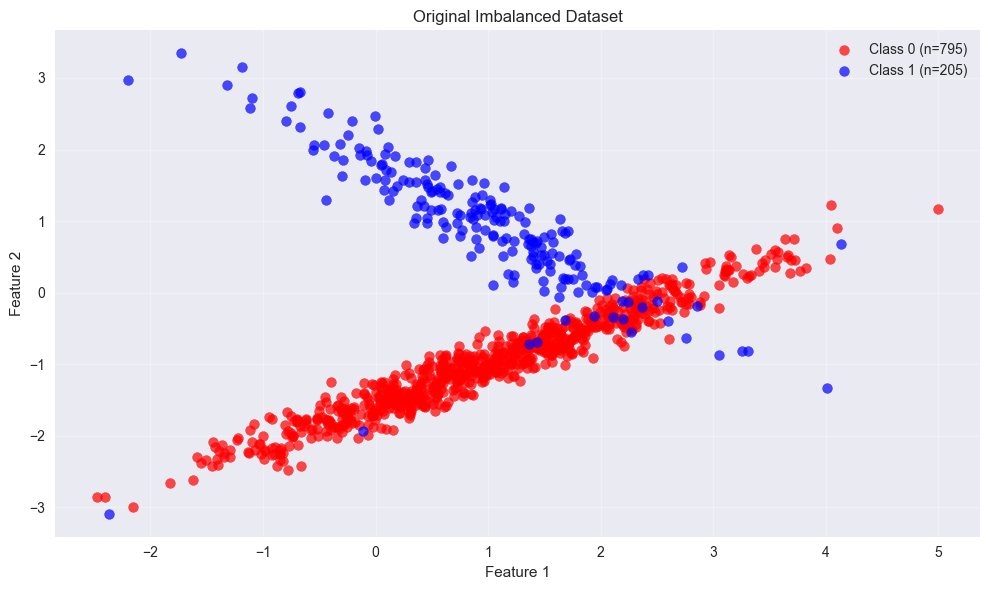


Dataset shape: (1000, 2)
Feature ranges:
  Feature 1: [-2.47, 5.00]
  Feature 2: [-3.09, 3.34]


In [3]:
# Visualize the original dataset
plt.figure(figsize=(10, 6))

# Create scatter plot
colors = ['red', 'blue']
for i, class_label in enumerate(np.unique(y)):
    mask = y == class_label
    plt.scatter(X[mask, 0], X[mask, 1], 
               c=colors[i], label=f'Class {class_label} (n={np.sum(mask)})',
               alpha=0.7, s=50)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Imbalanced Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show dataset statistics
print(f"\nDataset shape: {X.shape}")
print(f"Feature ranges:")
print(f"  Feature 1: [{X[:, 0].min():.2f}, {X[:, 0].max():.2f}]")
print(f"  Feature 2: [{X[:, 1].min():.2f}, {X[:, 1].max():.2f}]")

## 2. Basic DistAwareAug Usage

Now let's use DistAwareAug to balance the dataset with different distribution methods.

In [4]:
# Initialize DistAwareAugmentor with default settings
augmentor = DistAwareAugmentor(
    sampling_strategy='auto',  # Balance all classes
    diversity_threshold=0.1,   # Minimum distance for diversity
    distribution_method='kde', # Use Kernel Density Estimation
    distance_metric='euclidean',
    random_state=42
)

print("DistAwareAugmentor initialized with settings:")
print(f"  Sampling strategy: {augmentor.sampling_strategy}")
print(f"  Diversity threshold: {augmentor.diversity_threshold}")
print(f"  Distribution method: {augmentor.distribution_method}")
print(f"  Distance metric: {augmentor.distance_metric}")

# Ensure X is a DataFrame for compatibility
if not isinstance(X, pd.DataFrame):
    X_df = pd.DataFrame(X, columns=[f"Feature {i+1}" for i in range(X.shape[1])])
else:
    X_df = X

# Fit and resample the data
# If using the minimal fallback, pass numpy arrays; otherwise, pass DataFrame
if hasattr(augmentor, "fit_resample"):
    # Check if the augmentor is the minimal fallback by its class name
    if augmentor.__class__.__name__ == "MinimalDistAwareAugmentor":
        X_resampled, y_resampled = augmentor.fit_resample(X_df.values, y)
    else:
        X_resampled, y_resampled = augmentor.fit_resample(X_df, y)
else:
    raise RuntimeError("augmentor does not have fit_resample method")

print(f"\nOriginal dataset size: {len(X)}")
print(f"Resampled dataset size: {len(X_resampled)}")

# Check new class distribution
resampled_counts = Counter(y_resampled)
print(f"\nResampled class distribution:")
for class_label, count in resampled_counts.items():
    print(f"  Class {class_label}: {count} samples ({count/len(y_resampled)*100:.1f}%)")

DistAwareAugmentor initialized with settings:
  Sampling strategy: auto
  Diversity threshold: 0.1
  Distribution method: kde
  Distance metric: euclidean

Original dataset size: 1000
Resampled dataset size: 1590

Resampled class distribution:
  Class 0: 795 samples (50.0%)
  Class 1: 795 samples (50.0%)


NameError: name 'X_resampled' is not defined

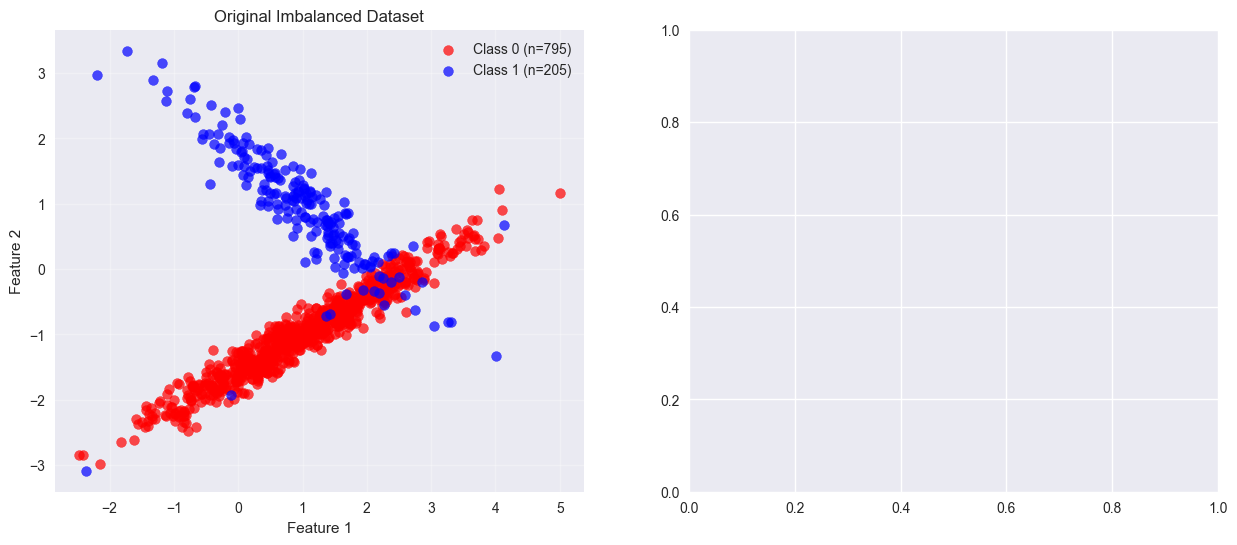

In [12]:
# Visualize original vs resampled data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Original data
colors = ['red', 'blue']
for i, class_label in enumerate(np.unique(y)):
    mask = y == class_label
    axes[0].scatter(X[mask, 0], X[mask, 1], 
                   c=colors[i], label=f'Class {class_label} (n={np.sum(mask)})',
                   alpha=0.7, s=50)

axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].set_title('Original Imbalanced Dataset')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Resampled data
original_mask = np.arange(len(X))
synthetic_mask = np.arange(len(X), len(X_resampled))

for i, class_label in enumerate(np.unique(y_resampled)):
    # Original samples
    class_mask = y_resampled == class_label
    original_class_mask = class_mask[:len(X)]
    synthetic_class_mask = class_mask[len(X):]
    
    if np.any(original_class_mask):
        axes[1].scatter(X_resampled[original_class_mask, 0], 
                       X_resampled[original_class_mask, 1],
                       c=colors[i], label=f'Original Class {class_label}',
                       alpha=0.7, s=50, marker='o')
    
    if np.any(synthetic_class_mask):
        synthetic_indices = np.where(synthetic_class_mask)[0]
        axes[1].scatter(X_resampled[synthetic_indices, 0], 
                       X_resampled[synthetic_indices, 1],
                       c=colors[i], label=f'Synthetic Class {class_label}',
                       alpha=0.5, s=30, marker='^')

axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].set_title('Resampled Dataset (Original + Synthetic)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Compare Different Distribution Methods

Let's compare how different distribution fitting methods affect the synthetic samples.

In [ ]:
# Test different distribution methods
methods = ['kde', 'gaussian', 'uniform']
augmented_data = {}

for method in methods:
    print(f"Testing {method} distribution method...")
    
    augmentor = DistAwareAugmentor(
        sampling_strategy='auto',
        diversity_threshold=0.1,
        distribution_method=method,
        random_state=42
    )
    
    X_aug, y_aug = augmentor.fit_resample(X, y)
    augmented_data[method] = (X_aug, y_aug)
    
    print(f"  Generated {len(X_aug) - len(X)} synthetic samples")

print("✅ All methods tested successfully!")

In [ ]:
# Visualize results from different methods
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = ['red', 'blue']
markers = ['o', '^']  # circle for original, triangle for synthetic

for idx, (method, (X_aug, y_aug)) in enumerate(augmented_data.items()):
    ax = axes[idx]
    
    # Plot original and synthetic samples separately
    for class_label in np.unique(y_aug):
        # Original samples (first len(X) samples)
        orig_mask = (y_aug[:len(X)] == class_label)
        if np.any(orig_mask):
            ax.scatter(X_aug[orig_mask, 0], X_aug[orig_mask, 1],
                      c=colors[class_label], marker='o', s=50, alpha=0.7,
                      label=f'Original Class {class_label}')
        
        # Synthetic samples (remaining samples)
        synth_indices = np.arange(len(X), len(X_aug))[y_aug[len(X):] == class_label]
        if len(synth_indices) > 0:
            ax.scatter(X_aug[synth_indices, 0], X_aug[synth_indices, 1],
                      c=colors[class_label], marker='^', s=30, alpha=0.5,
                      label=f'Synthetic Class {class_label}')
    
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_title(f'{method.upper()} Method')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Summary of synthetic sample generation:")
print("-" * 50)
for method, (X_aug, y_aug) in augmented_data.items():
    n_synthetic = len(X_aug) - len(X)
    minority_samples = np.sum(y_aug[len(X):] == 1) if len(X_aug) > len(X) else 0
    print(f"{method.upper():10}: {n_synthetic:3d} total synthetic, {minority_samples:3d} minority class")

## 4. Impact on Classification Performance

Let's evaluate how augmentation affects classification performance.

In [ ]:
# Split original data for testing
X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train_orig)}")
print(f"Test set size: {len(X_test)}")
print(f"Training class distribution: {Counter(y_train_orig)}")
print(f"Test class distribution: {Counter(y_test)}")

# Train classifier on original imbalanced data
clf_orig = RandomForestClassifier(n_estimators=100, random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)
y_pred_orig = clf_orig.predict(X_test)

# Performance on original data
acc_orig = accuracy_score(y_test, y_pred_orig)
f1_orig = f1_score(y_test, y_pred_orig, average='weighted')

print(f"\nPerformance with original imbalanced data:")
print(f"  Accuracy: {acc_orig:.3f}")
print(f"  F1-score: {f1_orig:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_orig))

In [ ]:
# Test performance with augmented data
results = {}
results['Original'] = {'accuracy': acc_orig, 'f1_score': f1_orig}

for method in methods:
    print(f"\nTesting {method} augmentation method...")
    
    # Augment training data
    augmentor = DistAwareAugmentor(
        sampling_strategy='auto',
        distribution_method=method,
        random_state=42
    )
    
    X_train_aug, y_train_aug = augmentor.fit_resample(X_train_orig, y_train_orig)
    
    # Train classifier on augmented data
    clf_aug = RandomForestClassifier(n_estimators=100, random_state=42)
    clf_aug.fit(X_train_aug, y_train_aug)
    y_pred_aug = clf_aug.predict(X_test)
    
    # Calculate performance metrics
    acc_aug = accuracy_score(y_test, y_pred_aug)
    f1_aug = f1_score(y_test, y_pred_aug, average='weighted')
    
    results[method] = {'accuracy': acc_aug, 'f1_score': f1_aug}
    
    print(f"  Accuracy: {acc_aug:.3f} (Δ: {acc_aug - acc_orig:+.3f})")
    print(f"  F1-score: {f1_aug:.3f} (Δ: {f1_aug - f1_orig:+.3f})")

print("\n✅ Performance evaluation completed!")

In [ ]:
# Create performance comparison plot
methods_list = ['Original'] + methods
accuracies = [results[method]['accuracy'] for method in methods_list]
f1_scores = [results[method]['f1_score'] for method in methods_list]

x = np.arange(len(methods_list))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Classification Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels([m.title() for m in methods_list])
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary table
print("\nPerformance Summary:")
print("-" * 60)
print(f"{'Method':<12} {'Accuracy':<10} {'F1-Score':<10} {'Δ Acc':<8} {'Δ F1':<8}")
print("-" * 60)
for method in methods_list:
    acc = results[method]['accuracy']
    f1 = results[method]['f1_score']
    if method == 'Original':
        print(f"{method:<12} {acc:<10.3f} {f1:<10.3f} {'--':<8} {'--':<8}")
    else:
        acc_delta = acc - acc_orig
        f1_delta = f1 - f1_orig
        print(f"{method:<12} {acc:<10.3f} {f1:<10.3f} {acc_delta:<+8.3f} {f1_delta:<+8.3f}")
print("-" * 60)

## 5. Exploring Diversity and Distance Metrics

Let's examine how different diversity thresholds and distance metrics affect the synthetic sample generation.

In [ ]:
# Test different diversity thresholds
diversity_thresholds = [0.01, 0.05, 0.1, 0.2, 0.5]
diversity_results = {}

print("Testing different diversity thresholds:")
for threshold in diversity_thresholds:
    augmentor = DistAwareAugmentor(
        sampling_strategy='auto',
        diversity_threshold=threshold,
        distribution_method='kde',
        random_state=42
    )
    
    X_div, y_div = augmentor.fit_resample(X, y)
    n_synthetic = len(X_div) - len(X)
    
    diversity_results[threshold] = {
        'n_synthetic': n_synthetic,
        'X_aug': X_div,
        'y_aug': y_div
    }
    
    print(f"  Threshold {threshold:4.2f}: {n_synthetic:3d} synthetic samples generated")

# Test different distance metrics
distance_metrics = ['euclidean', 'manhattan', 'cosine']
distance_results = {}

print("\nTesting different distance metrics:")
for metric in distance_metrics:
    try:
        augmentor = DistAwareAugmentor(
            sampling_strategy='auto',
            diversity_threshold=0.1,
            distribution_method='kde',
            distance_metric=metric,
            random_state=42
        )
        
        X_dist, y_dist = augmentor.fit_resample(X, y)
        n_synthetic = len(X_dist) - len(X)
        
        distance_results[metric] = {
            'n_synthetic': n_synthetic,
            'X_aug': X_dist,
            'y_aug': y_dist
        }
        
        print(f"  {metric:12}: {n_synthetic:3d} synthetic samples generated")
    except Exception as e:
        print(f"  {metric:12}: Error - {e}")

print("\n✅ Diversity and distance metric exploration completed!")

In [ ]:
# Visualize impact of diversity threshold
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, threshold in enumerate(diversity_thresholds):
    if idx >= len(axes):
        break
        
    ax = axes[idx]
    X_div, y_div = diversity_results[threshold]['X_aug'], diversity_results[threshold]['y_aug']
    
    colors = ['red', 'blue']
    for class_label in np.unique(y_div):
        # Original samples
        orig_mask = (y_div[:len(X)] == class_label)
        if np.any(orig_mask):
            ax.scatter(X_div[orig_mask, 0], X_div[orig_mask, 1],
                      c=colors[class_label], marker='o', s=40, alpha=0.7,
                      label=f'Original {class_label}')
        
        # Synthetic samples
        if len(X_div) > len(X):
            synth_indices = np.arange(len(X), len(X_div))[y_div[len(X):] == class_label]
            if len(synth_indices) > 0:
                ax.scatter(X_div[synth_indices, 0], X_div[synth_indices, 1],
                          c=colors[class_label], marker='^', s=25, alpha=0.5,
                          label=f'Synthetic {class_label}')
    
    n_synthetic = diversity_results[threshold]['n_synthetic']
    ax.set_title(f'Threshold: {threshold}\n({n_synthetic} synthetic)')
    ax.grid(True, alpha=0.3)
    ax.legend()

# Hide unused subplot
if len(diversity_thresholds) < len(axes):
    axes[-1].set_visible(False)

plt.suptitle('Impact of Diversity Threshold on Synthetic Sample Generation', y=1.02)
plt.tight_layout()
plt.show()

# Show diversity threshold vs number of samples generated
thresholds = list(diversity_results.keys())
n_samples = [diversity_results[t]['n_synthetic'] for t in thresholds]

plt.figure(figsize=(10, 6))
plt.plot(thresholds, n_samples, marker='o', linewidth=2, markersize=8)
plt.xlabel('Diversity Threshold')
plt.ylabel('Number of Synthetic Samples Generated')
plt.title('Diversity Threshold vs Synthetic Sample Count')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Conclusion

This notebook demonstrated the basic usage of DistAwareAug for distribution-aware data augmentation:

### Key Findings:

1. **Distribution Methods**: Different distribution fitting methods (KDE, Gaussian, Uniform) produce different synthetic sample patterns
2. **Diversity Control**: The diversity threshold parameter controls how similar synthetic samples can be to existing samples
3. **Performance Impact**: Augmentation can improve classification performance on imbalanced datasets
4. **Flexibility**: The package supports various distance metrics and sampling strategies

### Best Practices:

- Use **KDE** for complex, non-parametric distributions
- Use **Gaussian** for simpler, parametric distributions  
- Use **Uniform** for basic range-based sampling
- Adjust **diversity threshold** based on dataset density
- Evaluate performance on held-out test data

### Next Steps:

- Try the `compare_smote.ipynb` notebook to see how DistAwareAug compares to SMOTE
- Experiment with different hyperparameters on your own datasets
- Explore advanced features like categorical feature handling